<a href="https://colab.research.google.com/github/arnauatgithub/BeanBag/blob/master/DERMOPATOLOGIC_svm_nn_FULL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dermoscopy images classification
* This nootebook proceses the images of Dermoscopy images Dataset.
* Include the py files of the project in google drive  and add them as sys.path.append.
* Include the dataset for dermoscopy to google drive and load it path as the variable path.
* Use the generated CSV and npy files of the project that contains the features lesions.
* The components to process new images are loaded in this notebook

WARNING!! This colab notebook takes arround 8 hours to complete, most of the time colab logs out, it is highly recommended to run this notebook offline.

Mount Google Drive to the current environment:

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Append python files to the path:

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/dermo_safe_new')

*Install* required packages used for feature extraction:

In [0]:
!pip install mahotas
!pip install pyradiomics 
!pip install SimpleITK 

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
The folder you are executing pip from can no longer be found.


## Prepare the datasets 


First, generate feature files without segmentation

In [0]:
from feature_extraction.training_data import prepare_dataset
path_train = 'gdrive/My Drive/dataset_dermo/train'
prepare_dataset(path_train, "train_no_segm", segm_alg = None)

In [0]:
from feature_extraction.training_data import prepate_datasets_no_segm
path_val = 'gdrive/My Drive/dataset_dermo/val'
prepare_dataset(path_val, "val_no_segm", segm_alg=None)

At this point 4 files have been generated in folders train and val, corresponding to feature vector and metadata for both datasets for the case of no segmentation. Please go to your Google Drive and move those files to another folder.

Now features with segmentation are generated

In [0]:
prepare_dataset(path_train, "train_segm", segm_alg = "ws")
prepare_dataset(path_val, "val_segm", segm_alg="ws")

Two new files have been generated. Please move these files to the folder where you put the other two files previously.

## Open the feature files


In this part of the notebook the feature files generated previously are read. Make sure the path of the files corresponds to the folder where you put all 4 files previously.

In [0]:
import numpy as np

Read metadata first:

In [0]:
import pandas as pd
train_metadata = pd.read_csv('gdrive/My Drive/features_train_validation/train_segm.csv')
val_metadata = pd.read_csv('gdrive/My Drive/features_train_validation/val_segm.csv')
Y_train = (train_metadata.iloc[:, -1] == 'les').to_numpy() * 1
Y_val = (val_metadata.iloc[:, -1] == 'les').to_numpy() * 1

Read feature vectors

In [0]:
X_train = np.load('gdrive/My Drive/features_train_validation/train_segm.npy')
X_val = np.load('gdrive/My Drive/features_train_validation/val_segm.npy')

Read features file that does not have segmentation:

In [0]:
train_metadata_2 = pd.read_csv('gdrive/My Drive/features_train_validation/train_no_segm.csv')
val_metadata_2 = pd.read_csv('gdrive/My Drive/features_train_validation/val_no_segm.csv')
Y_train_2 = (train_metadata_2.iloc[:, -1] == 'les').to_numpy() * 1
Y_val_2 = (val_metadata_2.iloc[:, -1] == 'les').to_numpy() * 1

In [0]:
X_train_2 = np.load('gdrive/My Drive/features_train_validation/train_no_segm.npy')
X_val_2 = np.load('gdrive/My Drive/features_train_validation/val_no_segm.npy')

In [0]:
X_train = np.concatenate((X_train, X_train_2), axis = 1)
X_val = np.concatenate((X_val, X_val_2), axis=1)
X_train.shape

(4800, 1290)

Join training and validation features

In [0]:
X_train = np.concatenate((X_train, X_val), axis = 0)
Y_train = np.concatenate((Y_train, Y_val), axis = 0)

In [0]:
X_train.shape


(6000, 1290)

## Normalize data


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [0]:
X_train.shape

(6000, 1290)

## Perform feature selection

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf1 = ExtraTreesClassifier(n_estimators=100)
clf1 = clf1.fit(X_train, Y_train)
#Take most important N features:
#N = 284
#imp = clf1.feature_importances_
#feat_ind = imp.argsort()[-N:][::-1]
#X_train = X_train[:,feat_ind]
#X_val = X_val[:,feat_ind]

#Or take as many as the tool says:
model = SelectFromModel(clf1, prefit=True)
X_train = model.transform(X_train)
X_val = model.transform(X_val)

In [0]:
X_train.shape

(6000, 1290)

## SVM CLASSIFIER

In [0]:
import numpy as np
import pandas as pd
from sklearn import svm

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score

Define and fit SVM to data





In [0]:
clf_svm = svm.SVC(C=3, gamma='scale', kernel = 'rbf', probability = True)
clf_svm.fit(X_train, Y_train)

SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

#### Evaluate results on validation set


In [0]:
pred_val = clf_svm.predict(X_val)
pred_train = clf_svm.predict(X_train)

In [0]:
from sklearn.metrics import roc_curve, auc,accuracy_score, confusion_matrix
confusion_matrix(Y_val, pred_val)

array([[535,  65],
       [ 58, 542]])

In [0]:
acc = accuracy_score(Y_val, pred_val)
print("Accuracy in validation set: ", acc)

0.8975

In [0]:
confusion_matrix(Y_train, pred_train)

array([[2319,   81],
       [  56, 2344]])

In [0]:
acc_tr = accuracy_score(Y_train, pred_train)
print("Accuracty in training: ", acc_tr)

0.9714583333333333

In [0]:
probs_svm = clf_svm.predict_proba(X_val)
probs_svm = probs_svm[:,1]

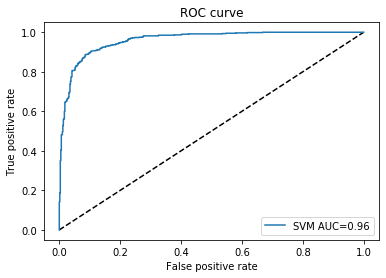

In [0]:
from sklearn.metrics import roc_curve, auc,accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
fpr_svm, tpr_svm, thresholds = roc_curve(Y_val, probs_svm)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_svm, tpr_svm, label='SVM AUC='+'{0:.2f}'.format(auc(fpr_svm, tpr_svm)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Logistic regression

In [0]:
from sklearn.linear_model import LogisticRegression
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, Y_train)
pred_val_lr = logreg_clf.predict(X_val)
confusion_matrix(Y_val, pred_val_lr)
acc_lr = accuracy_score(Y_val, pred_val_lr)
print("Accuracy for validation set: ", acc_lr)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8575

In [0]:
probs_logreg = logreg_clf.predict_proba(X_val)
probs_logreg = probs_logreg[:,1]

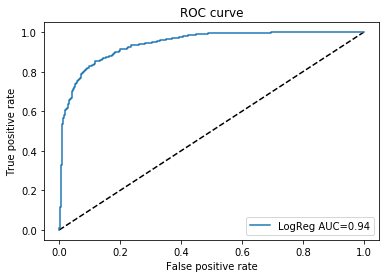

In [0]:
from sklearn.metrics import roc_curve, auc,accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
fpr_lg, tpr_lg, thresholds = roc_curve(Y_val, probs_logreg)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lg, tpr_lg, label='LogReg AUC='+'{0:.2f}'.format(auc(fpr_lg, tpr_lg)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Adaboost


In [0]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
clf_AB = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_AB.fit(X_train, Y_train)
pred_val_AB = clf_AB.predict(X_val)

In [0]:
confusion_matrix(Y_val, pred_val_AB)


array([[504,  96],
       [ 87, 513]])

In [0]:
acc_ab = accuracy_score(Y_val, pred_val_AB)
print("Accuracy for validation set: ", acc_ab)

0.8475

In [0]:
probs_ada = clf_AB.predict_proba(X_val)
probs_ada = probs_ada[:,1]

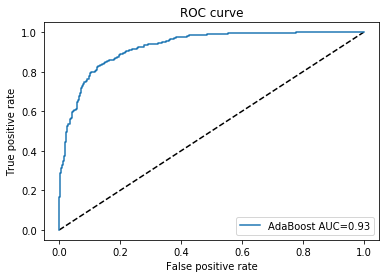

In [0]:
from sklearn.metrics import roc_curve, auc,accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
fpr_ab, tpr_ab, thresholds = roc_curve(Y_val, probs_ada)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ab, tpr_ab, label='AdaBoost AUC='+'{0:.2f}'.format(auc(fpr_ab, tpr_ab)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Neural network

In [0]:
from sklearn.neural_network import MLPClassifier

In [0]:
clf_nn = MLPClassifier(hidden_layer_sizes=(100,100), activation='relu', solver='adam', max_iter=500, random_state=9)

In [0]:
clf_nn.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=9, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
pred_val_nn = clf_nn.predict(X_val)

In [0]:
confusion_matrix(Y_val, pred_val_nn)

array([[520,  80],
       [ 63, 537]])

In [0]:
acc_nn = accuracy_score(Y_val, pred_val_nn)
print("Accuracy for validation set: ", acc_nn)

0.8808333333333334

In [0]:
probs_nn = clf_nn.predict_proba(X_val)
probs_nn = probs_nn[:,1]

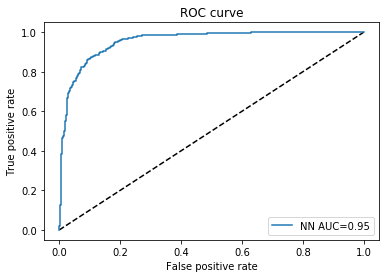

In [0]:
from sklearn.metrics import roc_curve, auc,accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
fpr_nn, tpr_nn, thresholds = roc_curve(Y_val, probs_nn)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nn, tpr_nn, label='NN AUC='+'{0:.2f}'.format(auc(fpr_nn, tpr_nn)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=50, max_depth=6, max_features = X_train.shape[1], random_state=0)

In [0]:
clf_rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features=284, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
pred_RF = clf_rf.predict(X_val)
probs_RF = clf_rf.predict_proba(X_val)
probs_RF=probs_RF[:,1]

In [0]:
confusion_matrix(Y_val, pred_RF)

array([[484, 116],
       [ 71, 529]])

In [0]:
acc_rf = accuracy_score(Y_val, pred_RF)
print("Accuracy for validation set: ", acc_rf)

0.8441666666666666

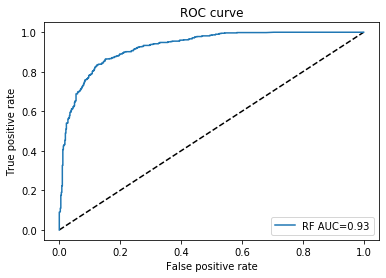

In [0]:
from sklearn.metrics import roc_curve, auc,accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
fpr_rf, tpr_rf, thresholds = roc_curve(Y_val, probs_RF)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF AUC='+'{0:.2f}'.format(auc(fpr_rf, tpr_rf)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
pred_train_RF = clf_rf.predict(X_train)
acc_tr_rf = accuracy_score(Y_train, pred_train_RF)
print("Accuracy for training: ", acc_tr_rf)

0.89125

## XG Boost


In [0]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [0]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
params = {
    'objective':'binary:logistic',
    'max_depth':10,
    'silent':1,
    'eta':1
}
num_rounds = 50
train_labels = dtrain.get_label()
ratio = 0.5
#float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio
bst_model = params, num_rounds
print(ratio)

0.5


In [0]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_val)

params, num_rounds = bst_model

bst = xgb.train(params, dtrain, num_rounds)
probability = bst.predict(dtest)

In [0]:
print("Accuracy for validation set: ", accuracy_score(Y_val, probability>0.5))

0.875


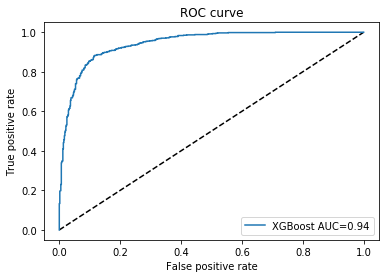

In [0]:
from sklearn.metrics import roc_curve, auc,accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
fpr_xg, tpr_xg, thresholds = roc_curve(Y_val, probability)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xg, tpr_xg, label='XGBoost AUC='+'{0:.2f}'.format(auc(fpr_xg, tpr_xg)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Plot all ROCs together

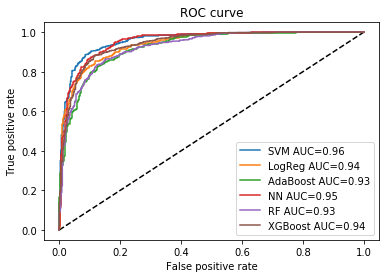

In [0]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_svm, tpr_svm, label='SVM AUC='+'{0:.2f}'.format(auc(fpr_svm, tpr_svm)))
plt.plot(fpr_lg, tpr_lg, label='LogReg AUC='+'{0:.2f}'.format(auc(fpr_lg, tpr_lg)))
plt.plot(fpr_ab, tpr_ab, label='AdaBoost AUC='+'{0:.2f}'.format(auc(fpr_ab, tpr_ab)))
plt.plot(fpr_nn, tpr_nn, label='NN AUC='+'{0:.2f}'.format(auc(fpr_nn, tpr_nn)))
plt.plot(fpr_rf, tpr_rf, label='RF AUC='+'{0:.2f}'.format(auc(fpr_rf, tpr_rf)))
plt.plot(fpr_xg, tpr_xg, label='XGBoost AUC='+'{0:.2f}'.format(auc(fpr_xg, tpr_xg)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Ensemble

In [0]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [0]:
eclf1 = VotingClassifier(estimators=[('svm', clf_svm), ('lg', logreg_clf), ('nn', clf_nn)], voting='soft')

In [0]:
eclf1 = eclf1.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
preds_ensemble = eclf1.predict(X_val)

In [0]:
acc_ensemble = accuracy_score(Y_val, preds_ensemble)
print("Accuracy for validation set: ", acc_ensemble)

0.8958333333333334

In [0]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc,accuracy_score, confusion_matrix
from sklearn.model_selection import KFold

In [0]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [0]:
kfold = KFold(5, True, 1)
models = []
accuracies_svm = []
accuracies_xgb = []
accuracies_lr = []
accuracies_ab = []
accuracies_nn = []
accuracies_rf = []
fold_counter = 1
for train_index, test_index in kfold.split(X_train):
  print("Current fold: ", fold_counter)
  x_train, x_test = X_train[train_index], X_train[test_index]
  y_train, y_test = Y_train[train_index], Y_train[test_index]
  #Normalize here
  scaler = StandardScaler()
  scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_test = scaler.transform(x_test)
  #SVM
  print("Training SVM...")
  clf_svm = svm.SVC(C=3, gamma='scale', kernel = 'rbf', probability = True)
  clf_svm.fit(x_train, y_train)
  pred_svm = clf_svm.predict(x_test)
  acc = accuracy_score(y_test, pred_svm)
  accuracies_svm.append(acc)
  print(acc)

  #XGB
  print("Training XGB...")
  dtrain = xgb.DMatrix(x_train, label=y_train)
  params = {
      'objective':'binary:logistic',
      'max_depth':10,
      'silent':1,
      'eta':1
  }
  num_rounds = 50
  train_labels = dtrain.get_label()
  ratio = 0.5
  #float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
  params['scale_pos_weight'] = ratio
  bst_model = params, num_rounds
  dtrain = xgb.DMatrix(x_train, label=y_train)
  dtest = xgb.DMatrix(x_test)

  params, num_rounds = bst_model

  bst = xgb.train(params, dtrain, num_rounds)
  probability = bst.predict(dtest)
  acc = accuracy_score(y_test, probability>0.5)
  accuracies_xgb.append(acc)
  print(acc)

  #LR
  print("Training LR...")
  logreg_clf = LogisticRegression()
  logreg_clf.fit(x_train, y_train)
  pred_val_lr = logreg_clf.predict(x_test)
  acc = accuracy_score(y_test, pred_val_lr)
  accuracies_lr.append(acc)
  print(acc)

  #AB
  print("Training AB...")
  clf_AB = AdaBoostClassifier(n_estimators=100, random_state=0)
  clf_AB.fit(x_train, y_train)
  pred_AB = clf_AB.predict(x_test)
  acc = accuracy_score(y_test, pred_AB)
  accuracies_ab.append(acc)
  print(acc)

  #NN
  print("Training NN...")
  clf_nn = MLPClassifier(hidden_layer_sizes=(100,100), activation='relu', solver='adam', max_iter=500, random_state=9)
  clf_nn.fit(x_train, y_train)
  pred_nn = clf_nn.predict(x_test)
  acc = accuracy_score(y_test, pred_nn)
  accuracies_nn.append(acc)
  print(acc)

  #RF
  print("Training RF...")
  clf_rf = RandomForestClassifier(n_estimators=50, max_depth=6, max_features = X_train.shape[1], random_state=0)
  clf_rf.fit(x_train, y_train)
  pred_RF = clf_rf.predict(x_test)
  acc = accuracy_score(y_test, pred_RF)
  accuracies_rf.append(acc)
  print(acc)

  fold_counter += 1